※ Global variables

In [1]:

import torch
print(torch.__version__)

import torchvision
print(torchvision.__version__)
gnDataset = 3
gBase_path = 'C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data'
gnClasses = 5

gDropout_rate = [0.5, 0.5, 0.5]
gBatch_momentum = [0.2, 0.2, 0.2]
gLearning_rate = [0.00001, 0.00001, 0.00001]
gWeight_decay = [1e-3, 1e-3, 1e-3]
gOpt_Momentum = [0.9, 0.9, 0.9]

gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 100
gbData_augmentation = True

gModel_names = ["cnn", "cnn", "cnn"] # "resnet", "cnn"
gOptimizer_names = ["Adam", "Adam", "Adam"] # "Adam", "SGD"
gCriterion_names = ["CrossEntropyLoss", "CrossEntropyLoss", "CrossEntropyLoss"]


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.6.0+cu118
0.21.0+cu118
cuda:0


※ Widget functions

In [16]:
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms import ToTensor
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class CAS771Plot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1

    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)

    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1

        if self.patience_counter >= gEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None

    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def load_data(train_data_path, test_data_path, m=0, save_class_mapping=True):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted(set(train_labels))
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(f"Class mapping: {class_mapping}")

    if train_data_path == None:
        train_dataloader = None
    else:
        # mapping the class to class_index
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train")
        train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)

        if save_class_mapping:
            # Save the mapping to a file
            class_mapping_path = f'{gBase_path}/Model{m+1}/class_mapping_model_{m+1}.pkl'
            with open(class_mapping_path, "wb") as f:
                pickle.dump(class_mapping, f)

    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test")
        test_dataset = CAS771Dataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

※ Datasets

In [7]:
train_data_paths = [f'{gBase_path}/Model{i}/model{i}_train.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/Model{i}/model{i}_test.pth' for i in range(1, gnDataset+1)]
print(train_data_paths)
print(test_data_paths)

classes_path = gBase_path + '/cifar100_classes.txt'
classes = load_class_names(classes_path)
print(classes)

['C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model1/model1_train.pth', 'C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model2/model2_train.pth', 'C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model3/model3_train.pth']
['C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model1/model1_test.pth', 'C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model2/model2_test.pth', 'C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model3/model3_test.pth']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'li

※ Models

1. ResNet18

In [3]:
# Define Basic Block (Residual Block)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0, batch_momentum=0.1):
        super(BasicBlock, self).__init__()
        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)

        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)

        # Skip connection (identity)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels, momentum=batch_momentum)
            )

        # Dropout Layer (After Batch Normalization)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Residual connection + ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # skip connection
        out = F.relu(out)
        return out

# Define Modified ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, batch_momentum=0.1):
        super(ResNet18, self).__init__()
        self.in_channels = 32
        # 1st Layer (Conv + Maxpool)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32, momentum=batch_momentum)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual Blocks (each block is BasicBlock)
        #self.layer0 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate/2)
        self.layer1 = self._make_layer(64, 2,
                                       stride=1, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)
        self.layer2 = self._make_layer(128, 2, stride=2,
                                       dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)
        self.layer4 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)
        # Fully Connected Layer
        self.fc = nn.Linear(256, num_classes)
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _make_layer(self, out_channels, num_blocks, stride, dropout_rate, batch_momentum):
        layers = []
        layers.append(BasicBlock(self.in_channels,
                                 out_channels,
                                 stride,
                                 dropout_rate=dropout_rate,
                                 batch_momentum=batch_momentum))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1st Convolution + Maxpool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        # Residual Blocks
        #x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Fully Connected
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(x)      # Apply Dropout
        x = self.fc(x)

        return x

2. CNN

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)

        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        self.in_features = dummy_output.view(1, -1).size(1)  # Store flattened size as an attribute

        # Fully connected layers
        self.fc1 = nn.Linear(self.in_features, 465)
        self.fc2 = nn.Linear(465, num_classes)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        self.feature_extractor = nn.Sequential(
            self.conv1, self.bn1, nn.ReLU(),
            self.pool1,  # Include the first pooling layer
            self.conv2, self.bn2, nn.ReLU(),
            self.conv3, self.bn3, nn.ReLU(),
            self.pool2
        )

    def forward(self, x):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


※ Model Functions

In [5]:
def _get_model(model_name, dropout_rate, batch_momentum, m = 0):
    if model_name == "resnet":
        model = ResNet18(num_classes=gnClasses,
                        dropout_rate=dropout_rate,
                        batch_momentum=batch_momentum).to(device)
    elif model_name == "cnn":
        model = CNN(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)


    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum):
    if opname == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_names, optimizer_names, criterion_names):
    models = []
    optimizers = []
    criterions = []
    for m in range(gnDataset):
        models.append(_get_model(model_names[m], gDropout_rate[m], gBatch_momentum[m], m))
        optimizers.append(_get_optimizer(optimizer_names[m], models[m], gLearning_rate[m], gWeight_decay[m], gOpt_Momentum[m]))
        criterions.append(_get_criterion(criterion_names[m]))

    return models, optimizers, criterions


def save_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    torch.save(model.state_dict(), model_saved_path)
    print(f"Model{m+1} is saved to: {model_saved_path}")

def load_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    model.load_state_dict(torch.load(model_saved_path))
    print(f"Model{m+1} is loaded from: {model_saved_path}")


2++※ Training / Validating for each model

Model1 parameters: 7993067
Model1 Total layers: 11
Model2 parameters: 7993067
Model2 Total layers: 11
Model3 parameters: 7993067
Model3 Total layers: 11
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Epoch 1, Train Loss: 1.1468, Validation Loss: 0.8571, Validation Accuracy: 0.6780
Epoch 2, Train Loss: 0.8461, Validation Loss: 0.7542, Validation Accuracy: 0.7160
Epoch 3, Train Loss: 0.7481, Validation Loss: 0.7001, Validation Accuracy: 0.7500
Epoch 4, Train Loss: 0.6819, Validation Loss: 0.6613, Validation Accuracy: 0.7540
Epoch 5, Train Loss: 0.6114, Validation Loss: 0.6510, Validation Accuracy: 0.7560
Epoch 6, Train Loss: 0.5814, Validation Loss: 0.6141, Validation Accuracy: 0.7660
Epoch 7, Train Loss: 0.5335, Validation Loss: 0.5933, Validation Accuracy: 0.7760
Epoch 8, Train Loss: 0.4886, Validation Loss: 0.5840, Validation Accuracy: 0.7840
Epoch 9, Train Loss: 0.4541, Validation Loss: 0.5820, Validation Accuracy: 0.7840
Epoch 10, Train Loss: 0.4267, Validation Loss: 0.5602, Vali

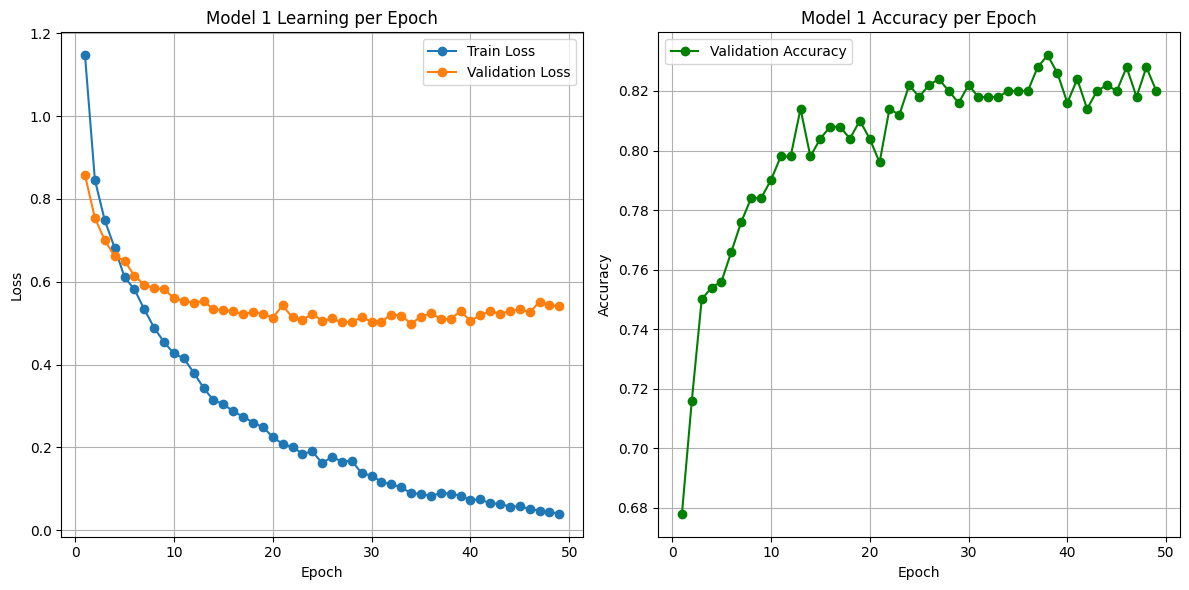

Model1 is saved to: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model1/model1_weights.pth
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Epoch 1, Train Loss: 1.2097, Validation Loss: 0.9355, Validation Accuracy: 0.6880
Epoch 2, Train Loss: 0.8879, Validation Loss: 0.7720, Validation Accuracy: 0.7160
Epoch 3, Train Loss: 0.7544, Validation Loss: 0.6892, Validation Accuracy: 0.7680
Epoch 4, Train Loss: 0.6706, Validation Loss: 0.6485, Validation Accuracy: 0.7520
Epoch 5, Train Loss: 0.6220, Validation Loss: 0.5965, Validation Accuracy: 0.7760
Epoch 6, Train Loss: 0.5669, Validation Loss: 0.5561, Validation Accuracy: 0.8040
Epoch 7, Train Loss: 0.5223, Validation Loss: 0.5414, Validation Accuracy: 0.8020
Epoch 8, Train Loss: 0.4617, Validation Loss: 0.5382, Validation Accuracy: 0.7900
Epoch 9, Train Loss: 0.4407, Validation Loss: 0.4878, Validation Accuracy: 0.8260
Epoch 10, Train Loss: 0.4109, Validation Loss: 0.5008, Validation Accuracy: 0.8240
Epoch 11, Train 

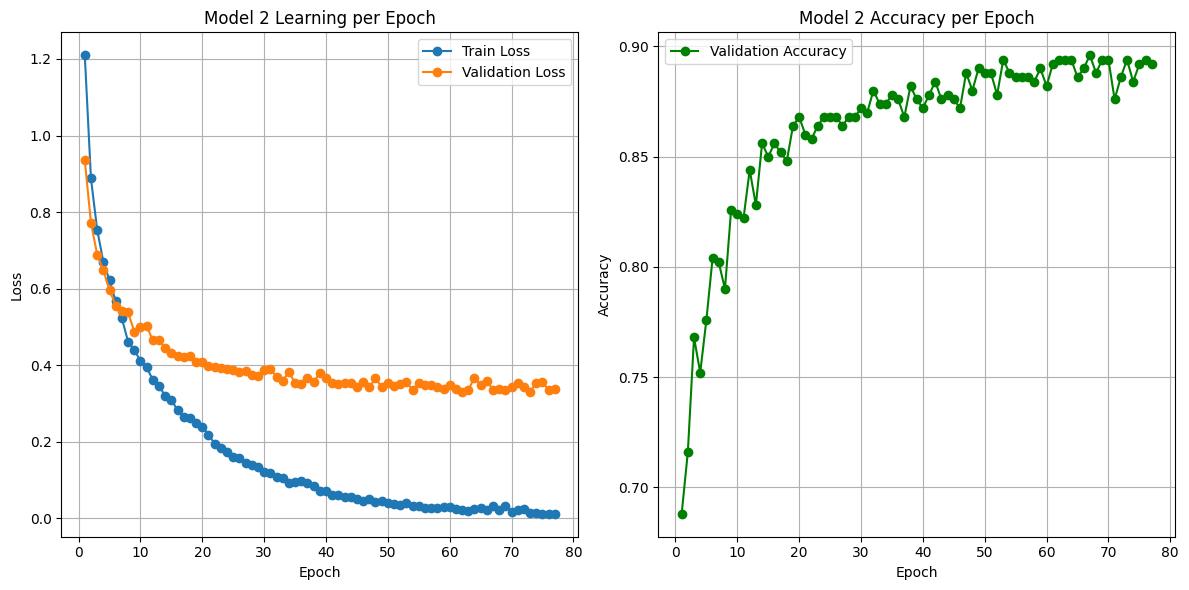

Model2 is saved to: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model2/model2_weights.pth
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Epoch 1, Train Loss: 1.3486, Validation Loss: 1.1208, Validation Accuracy: 0.6320
Epoch 2, Train Loss: 1.1107, Validation Loss: 0.9981, Validation Accuracy: 0.6580
Epoch 3, Train Loss: 0.9954, Validation Loss: 0.9237, Validation Accuracy: 0.6780
Epoch 4, Train Loss: 0.9021, Validation Loss: 0.8762, Validation Accuracy: 0.6840
Epoch 5, Train Loss: 0.8527, Validation Loss: 0.8510, Validation Accuracy: 0.6880
Epoch 6, Train Loss: 0.7879, Validation Loss: 0.8246, Validation Accuracy: 0.7160
Epoch 7, Train Loss: 0.7378, Validation Loss: 0.8112, Validation Accuracy: 0.7120
Epoch 8, Train Loss: 0.6970, Validation Loss: 0.7815, Validation Accuracy: 0.7320
Epoch 9, Train Loss: 0.6517, Validation Loss: 0.7624, Validation Accuracy: 0.7200
Epoch 10, Train Loss: 0.6185, Validation Loss: 0.7494, Validation Accuracy: 0.7160
Epoch 11, Train 

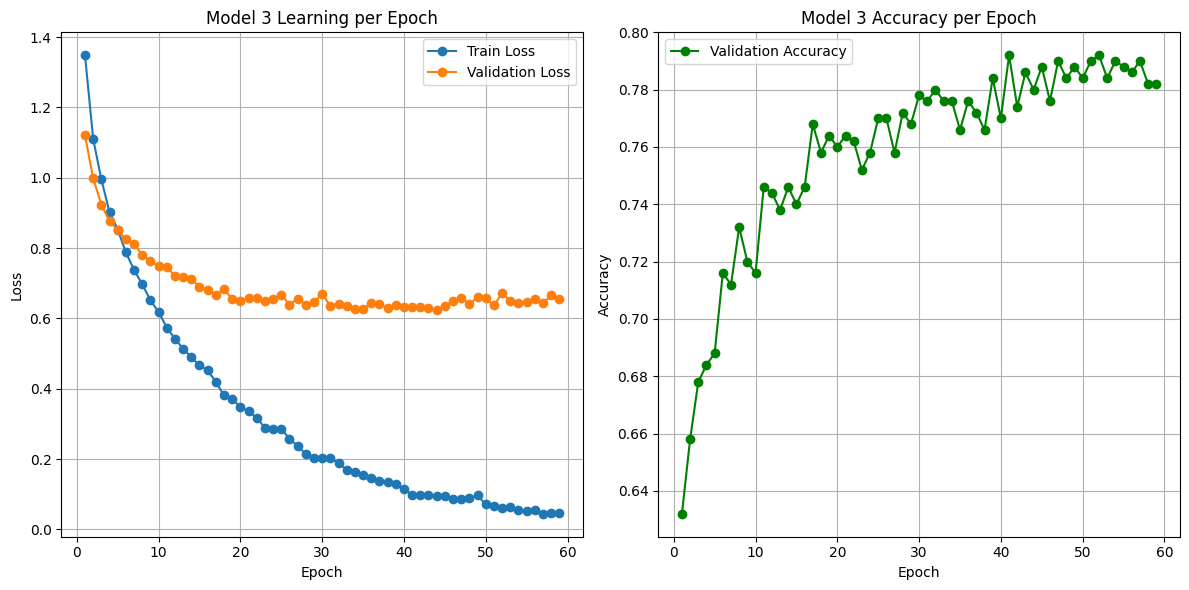

Model3 is saved to: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model3/model3_weights.pth


In [8]:
models, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)

for m in range(gnDataset):
    model = models[m]
    optimizer = optimizers[m]
    criterion = criterions[m]
    train_dataloader, test_dataloader = load_data(train_data_paths[m], test_data_paths[m], m)

    progress = CAS771Plot(model, criterion, device, train_dataloader, test_dataloader, m)
    es = CAS771EarlyStopping()

    for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())

        if es.isStop(progress.append(epoch)):
            break
    progress.plot()
    save_model(model, m)

    del model
torch.cuda.empty_cache()



In [10]:
# Define the dictionaries
data_accuracy_1 = {}
data_accuracy_2 = {}
data_accuracy_3 = {}

# Put the dictionaries in a list
data_accuracies = [data_accuracy_1, data_accuracy_2, data_accuracy_3]

Merging model: Bagging

In [13]:
# Function to evaluate accuracy with a dataloader
def evaluate_accuracy(model, dataloader, device, classes, debug=False):

    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, dim=1)  # Get predicted class

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Debugging information
            if debug:
                print(f"[Batch {batch_idx}] Original labels: {labels.cpu().numpy()}")
                print(f"[Batch {batch_idx}] Predicted: {predicted.cpu().numpy()}")

    # Calculate accuracy as a percentage
    accuracy = 100 * correct / total
    return accuracy

def majority_vote(models, dataloader, device):
    """
    Use majority voting to ensemble predictions from multiple models.
    """
    all_predictions = []
    for model in models:
        model.eval()
        predictions = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                predictions.append(torch.argmax(outputs, dim=1))  # Get class predictions
        all_predictions.append(torch.cat(predictions, dim=0))

    # Combine predictions using majority voting
    all_predictions = torch.stack(all_predictions, dim=0)  # Shape: (num_models, num_samples)

    majority_predictions = torch.mode(all_predictions, dim=0).values  # Majority vote
    return majority_predictions

def majority_vote_debug(models, dataloader, device):
    """
    Use majority voting to ensemble predictions from multiple models.
    Print predictions, true labels, and majority voting logic.
    """
    all_predictions = []
    true_labels = []  # To store the ground truth labels for comparison

    print("\n--- Collecting Predictions from Models ---")

    for model_idx, model in enumerate(models):
        model.eval()
        predictions = []  # Reset predictions for the current model
        model_predictions = []  # Store per-model predictions for printing

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_predictions = torch.argmax(outputs, dim=1)  # Get class predictions

                # Print batch-wise predictions
                #print(f"Model {model_idx}, Batch {batch_idx}: {batch_predictions}")

                predictions.append(batch_predictions)
                model_predictions.extend(batch_predictions.cpu().numpy())  # Convert to list for printing

                # Collect true labels (only once)
                if model_idx == 0:
                    true_labels.extend(labels.cpu().numpy())

        # Combine batch predictions for the current model
        predictions = torch.cat(predictions, dim=0)  # Concatenate batch predictions
        all_predictions.append(predictions)

        # Print predictions for the current model
        #print(f"\nModel {model_idx}: Final Predictions: {predictions}")

    # Collect all predictions in a tensor of shape (num_models, num_samples)
    all_predictions = torch.stack(all_predictions, dim=0)  # Shape: (num_models, num_samples)
    true_labels = torch.tensor(true_labels)  # Convert true labels to tensor for comparison

    # Perform majority voting across models
    majority_predictions, _ = torch.mode(all_predictions, dim=0)  # Get majority vote for each sample

    # Print majority voting logic
    print("\n--- Majority Voting Logic ---")
    cnt = 0
    for i in range(all_predictions.size(1)):  # Iterate over samples
        sample_predictions = all_predictions[:, i].cpu().numpy()  # Predictions for this sample from all models
        true_label = true_labels[i].item()
        final_prediction = majority_predictions[i].item()

        correct = (true_label == final_prediction)
        cnt += 1 if correct else 0

        print(
            f"Sample {i + 1}: Model Predictions: {sample_predictions}, "
            f"True Label: {true_label}, Final Prediction (Majority): {final_prediction}, correct:  {correct}, numerator: {cnt}, denominator:{i+1}"
        )

    return majority_predictions

# Loop through multiple models and datasets
for i in range(3):  # Iterate through models
    # Move the current model to the device
    model = models[i].to(device)

    for j in range(3):  # Iterate through datasets
        # Load the training and testing dataloaders for the current dataset
        train_dataloader, test_dataloader = load_data(train_data_paths[j], test_data_paths[j], j)

        # Evaluate the model on the test dataset
        accuracy = evaluate_accuracy(model, test_dataloader, device, gnClasses)

        # Print the accuracy

for j in range(3):
    # Load training and testing dataloaders
    train_dataloader, test_dataloader = load_data(train_data_paths[j], test_data_paths[j], j)

    # Get final predictions for the entire test dataset
    final_predictions = majority_vote(models, test_dataloader, device)
    final_predictions = torch.tensor(final_predictions).to(device)

    correct = 0
    total = 0
    start_idx = 0
    end_idx = 0
    # Iterate through test dataloader
    for batch_idx, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Calculate start and end index for the current batch
        start_idx = end_idx
        end_idx = start_idx +len(labels)
        outputs = final_predictions[start_idx:end_idx]

        # Debugging: Check alignment
        #print(f"Batch {batch_idx + 1}: Start Index: {start_idx}, End Index: {end_idx}")
        #print(f"Labels: {labels.tolist()}, Outputs: {outputs.tolist()}")

        # Update correct and total counts
        correct += (outputs == labels).sum().item()
        total += labels.size(0)

    # Calculate the accuracy
    accuracy = 100 * correct / total
    data_accuracies[j]["bagging"] = accuracy
    print(f"Ensemble Accuracy for Dataset {j}: {accuracy:.2f}%")

Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}


C:\Users\AdamBao\AppData\Local\Temp\ipykernel_14636\3533225992.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_predictions = torch.tensor(final_predictions).to(device)


Ensemble Accuracy for Dataset 0: 45.80%
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Ensemble Accuracy for Dataset 1: 52.40%
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Ensemble Accuracy for Dataset 2: 40.60%


Merging Model:Boosting

In [14]:
class BoostedModel:
    def __init__(self, models):
        self.models = models  # List of models passed as input
        self.alphas = []      # List to store the weights (alpha) for each model

    def fit(self, train_loaders, num_epochs=5, lr=0.0001, device="cuda"):
        # Initialize sample weights equally
        n_samples = [len(loader.dataset) for loader in train_loaders]
        sample_weights = [torch.ones(n, device=device) / n for n in n_samples]
        criterion = nn.CrossEntropyLoss(reduction="none")  # Use reduction="none" to get loss per sample

        for model_idx, model in enumerate(self.models):
            print(f"Training Weak Learner {model_idx + 1}...")
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train the model
            for epoch in range(num_epochs):
                model.train()
                for batch_idx, (inputs, labels) in enumerate(self.weighted_sampler_loader(train_loaders[model_idx], sample_weights[model_idx])):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.mean().backward()
                    optimizer.step()

            # Evaluate the model on the entire training dataset
            model.eval()
            all_preds = torch.zeros(n_samples[model_idx], dtype=torch.long, device=device)
            all_labels = torch.zeros(n_samples[model_idx], dtype=torch.long, device=device)
            with torch.no_grad():
                for batch_idx, (inputs, labels) in enumerate(train_loaders[model_idx]):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds[batch_idx * train_loaders[model_idx].batch_size : batch_idx * train_loaders[model_idx].batch_size + len(labels)] = preds
                    all_labels[batch_idx * train_loaders[model_idx].batch_size : batch_idx * train_loaders[model_idx].batch_size + len(labels)] = labels

            # Calculate weighted error
            incorrect = all_preds != all_labels
            error = torch.sum(sample_weights[model_idx][incorrect]) / torch.sum(sample_weights[model_idx])

            # Avoid division by zero or perfect predictions
            if error > 0.5:
                print(f"Weak Learner {model_idx + 1} has error > 0.5. Stopping early.")
                break
            if error == 0:
                print(f"Weak Learner {model_idx + 1} has zero error. Stopping early.")
                self.alphas.append(1)
                break

            # Calculate alpha for the current weak learner
            alpha = 0.5 * torch.log((1 - error) / error)
            self.alphas.append(alpha.item())
            print(f"alphas: {self.alphas}")

            # Update sample weights
            sample_weights[model_idx][incorrect] *= torch.exp(alpha)
            sample_weights[model_idx] /= torch.sum(sample_weights[model_idx])  # Normalize weights

            print(f"Weak Learner {model_idx + 1}: Error = {error:.4f}, Alpha = {alpha:.4f}")


    def weighted_sampler_loader(self, train_loader, sample_weights):
        # Create a WeightedRandomSampler based on the current sample weights
        sampler = WeightedRandomSampler(weights=sample_weights.cpu().numpy(), num_samples=len(sample_weights), replacement=True)
        dataset = train_loader.dataset
        batch_size = train_loader.batch_size

        weighted_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
        return weighted_loader

def predict_boost(models, alphas, test_loader, device="cuda"):
        combined_preds = None

        # Combine predictions from all models using their respective alphas
        for alpha, model in zip(alphas, models):     
            model = model.to(device)
            model.eval()
            with torch.no_grad():
                model_preds = []
                for inputs, labels in test_loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    outputs = alpha * outputs  # Scale the predictions by alpha
                    model_preds.append(outputs)
                model_preds = torch.cat(model_preds, dim=0)
                # Accumulate the predictions
                if combined_preds is None:
                    combined_preds = model_preds
                else:
                    combined_preds += model_preds

        # Final prediction: Take the class with the highest combined score
        final_preds = torch.argmax(combined_preds, dim=1)
        return final_preds


In [32]:
def train_boosted_model(boosted_model, train_dataloaders, test_dataloaders, num_epochs, device="cuda"):
    """
    Train the BoostedModel on three datasets using their respective dataloaders.

    Args:
        boosted_model (BoostedModel): Instance of BoostedModel containing weak learners.
        train_dataloaders (list): List of DataLoader objects for training datasets.
        test_dataloaders (list): List of DataLoader objects for test datasets.
        num_epochs (int): Number of epochs to train each weak learner.
        device (str): Device for training (e.g., "cuda" or "cpu").
    """
    # Ensure the number of weak learners matches the number of training datasets
    assert len(boosted_model.models) == len(train_dataloaders), "Number of models and datasets must match!"

    for model_idx, model in enumerate(boosted_model.models):
        print(f"Training Weak Learner {model_idx + 1} on Dataset {model_idx + 1}...")

        # Get the current training and test dataloaders for this weak learner
        train_loader = train_dataloaders[model_idx]
        test_loader = test_dataloaders[model_idx]

        # Train the current weak learner
        boosted_model.fit(train_dataloaders, num_epochs=num_epochs[model_idx], lr=0.001, device=device)
        print("Training Complete!")
    

models, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)
Epochs = [20, 20, 40]
base_path = gBase_path
train_dataloaders = []
test_dataloaders = []
for m in range(gnDataset):
    train_dataloader, test_dataloader = load_data(train_data_paths[m], test_data_paths[m], m)
    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)
boosted_model = BoostedModel(models)
train_boosted_model(boosted_model, train_dataloaders, test_dataloaders, num_epochs=Epochs, device=device)
combined_model_path = f"{base_path}/Model_merged/combined_model_boosting.pth"
combined_model = {
        "models": [model.state_dict() for model in boosted_model.models],
        "alphas": boosted_model.alphas,
    }
torch.save(combined_model, combined_model_path)
start_index = 0
end_index = 0
for test_idx, test_loader in enumerate(test_dataloaders):
    print(f"Evaluating Boosted Ensemble Model on Test Dataset {test_idx + 1}...")

    # Get predictions from the ensemble model on the current test dataset
    start_index = end_index
    end_index = start_index + 3
    alphas = boosted_model.alphas[start_index:end_index]
    predictions = predict_boost(boosted_model.models, alphas, test_loader, device)

    # Get the true labels for the test dataset
    true_labels = torch.cat([labels.to(device) for _, labels in test_loader], dim=0)

    # Check sizes to ensure alignment
    print(f"predictions: {predictions.size(0)}, true_labels: {true_labels.size(0)}")

    # Compute accuracy
    accuracy = (predictions == true_labels).float().mean().item()
    data_accuracies[test_idx]["boosting"] = accuracy* 100
    print(f"Boosted Ensemble Model Test Accuracy on Dataset {test_idx + 1}: {accuracy:.4f}")



Model1 parameters: 7993067
Model1 Total layers: 11
Model2 parameters: 7993067
Model2 Total layers: 11
Model3 parameters: 7993067
Model3 Total layers: 11
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Training Weak Learner 1 on Dataset 1...
Training Weak Learner 1...
alphas: [1.2377057075500488]
Weak Learner 1: Error = 0.0776, Alpha = 1.2377
Training Weak Learner 2...
alphas: [1.2377057075500488, 1.506970763206482]
Weak Learner 2: Error = 0.0468, Alpha = 1.5070
Training Weak Learner 3...
alphas: [1.2377057075500488, 1.506970763206482, 0.9193715453147888]
Weak Learner 3: Error = 0.1372, Alpha = 0.9194
Training Complete!
Training Weak Learner 2 on Dataset 2...
Training Weak Learner 1...
alphas: [1.2377057075500488, 1.506970763206482, 0.9193715453147888, 1.9996097087860107]
Weak Learner 1: Error = 0.0180, Alpha = 1.9996
Training Weak Learner 2...
alphas: [1.2377057075500488, 1.50697076320

3. Merging model: Gateway

In [18]:
class GatingNetwork(nn.Module):
    def __init__(self, num_sub_classifiers):
        super(GatingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for conv2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_sub_classifiers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Apply batch normalization
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Gateway date loader

In [19]:
def load_gateway_data(train_data_paths, test_data_paths):
    combined_train_dataset = []
    combined_test_dataset = []
    routing_class_mapping = {}  # Stores the mapping of datasets to routing labels (sub-classifier indices)
    # Prepare train and test datasets
    for m, (train_data_path, test_data_path) in enumerate(zip(train_data_paths, test_data_paths)):
        train_data, train_labels = _load_data(train_data_path) if train_data_path else (None, None)
        test_data, test_labels = _load_data(test_data_path) if test_data_path else (None, None)
        # Assign routing label (m corresponds to sub-classifier index)
        routing_label = m
        routing_class_mapping[f"Dataset {m+1}"] = routing_label  # Map Dataset m+1 to routing label m
        # Process training data
        if train_data is not None:
            transform = get_data_augmentation("train")
            routing_train_labels = [routing_label] * len(train_labels)  # Assign routing label to all samples
            train_dataset = CAS771Dataset(train_data, routing_train_labels, transform=transform)
            combined_train_dataset.append(train_dataset)
        # Process testing data
        if test_data is not None:
            transform = get_data_augmentation("test")
            routing_test_labels = [routing_label] * len(test_labels)  # Assign routing label to all samples
            test_dataset = CAS771Dataset(test_data, routing_test_labels, transform=transform)
            combined_test_dataset.append(test_dataset)
            # Combine datasets
    if combined_train_dataset:
        combined_train_dataset = ConcatDataset(combined_train_dataset)  # Combine all training datasets
        train_dataloader = DataLoader(combined_train_dataset, batch_size=gData_batch_size, shuffle=True)
    else:
        train_dataloader = None

    if combined_test_dataset:
        combined_test_dataset = ConcatDataset(combined_test_dataset)  # Combine all testing datasets
        test_dataloader = DataLoader(combined_test_dataset, batch_size=gData_batch_size, shuffle=False)
    else:
        test_dataloader = None
    return train_dataloader, test_dataloader

Train the gateway

In [20]:
# Training parameters
def save_gate_model(model):
    model_saved_path = f"{gBase_path}/Gateway/gateway_weights.pth"
    torch.save(model.state_dict(), model_saved_path)
    print(f"Model is saved to: {model_saved_path}")
    
def train_gating_network(gate_model, train_dataloader,test_dataloader, optimizer, criterion, n_epochs, device):

    for epoch in range(n_epochs):
        correct = 0
        total = 0
        total_test = 0
        correct_test = 0
        gate_model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, routing_labels in train_dataloader:
            # Move data to the device (CPU/GPU)
            inputs, routing_labels = inputs.to(device), routing_labels.to(device)

            # Forward pass
            optimizer.zero_grad()  # Clear previous gradients
            outputs = gate_model(inputs)  # Get probabilities for sub-classifiers

            # Compute the loss
            loss = criterion(outputs, routing_labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            correct += (predicted == routing_labels).sum().item()  # Count correct predictions
            total += routing_labels.size(0)  # Total number of samples
        
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = gate_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
        accuracy_test = correct_test / total_test * 100
        

        # Compute accuracy for the epoch
        accuracy = correct / total * 100
        
        # Print epoch loss and accuracy
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%, test_val: {accuracy_test:.2f}%")
    save_gate_model(gate_model)

def test_gateway_network(gate_model, test_dataloader, device):
    gate_model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = gate_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total * 100
        print(f"accuracy: {accuracy}")
        
gate_model = GatingNetwork(num_sub_classifiers = gnDataset).to(device)
#optimizer = _get_optimizer(gOptimizer_names[0], gate_model, learning_rate=0.001, weight_decay=gWeight_decay[0], opt_momentum=gOpt_Momentum[0])  # Adam optimizer
optimizer = torch.optim.Adam(gate_model.parameters(), lr=0.0001) 
criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss criterion
n_epochs = 150  # Number of epochs to train
train_dataloader, test_dataloader = load_gateway_data(train_data_paths, test_data_paths)
train_gating_network(gate_model=gate_model,train_dataloader= train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer, criterion=criterion,n_epochs=n_epochs,device=device)
#test_gateway_network(gateway_model=gate_model, test_dataloader=test_dataloader, device=device)

    

Epoch [1/150], Loss: 215.5048, Accuracy: 57.01%, test_val: 53.00%
Epoch [2/150], Loss: 180.2420, Accuracy: 66.48%, test_val: 57.07%
Epoch [3/150], Loss: 159.3665, Accuracy: 71.17%, test_val: 60.93%
Epoch [4/150], Loss: 143.3154, Accuracy: 75.01%, test_val: 62.73%
Epoch [5/150], Loss: 129.7607, Accuracy: 77.84%, test_val: 63.40%
Epoch [6/150], Loss: 116.3638, Accuracy: 80.08%, test_val: 65.00%
Epoch [7/150], Loss: 105.2340, Accuracy: 82.61%, test_val: 66.80%
Epoch [8/150], Loss: 96.8529, Accuracy: 84.29%, test_val: 67.20%
Epoch [9/150], Loss: 83.7189, Accuracy: 87.52%, test_val: 66.27%
Epoch [10/150], Loss: 73.6339, Accuracy: 88.99%, test_val: 67.87%
Epoch [11/150], Loss: 64.2483, Accuracy: 90.93%, test_val: 68.80%
Epoch [12/150], Loss: 56.6693, Accuracy: 92.03%, test_val: 65.40%
Epoch [13/150], Loss: 47.6928, Accuracy: 94.03%, test_val: 68.00%
Epoch [14/150], Loss: 41.8311, Accuracy: 95.12%, test_val: 70.60%
Epoch [15/150], Loss: 35.1759, Accuracy: 96.44%, test_val: 69.33%
Epoch [16/15

Gateway-Direct

In [38]:
def direct_to_submodels(gateway_model, submodels, dataloader, idx , device):

    gateway_model.eval()  # Set the gateway model to evaluation mode
    for submodel in submodels:
        submodel.eval()  # Set all submodels to evaluation mode

    # Initialize dictionaries for routing and results
    routed_data = {i: [] for i in range(len(submodels))}  # Data routed to each submodel
    routed_labels = {i: [] for i in range(len(submodels))}  # Labels routed to each submodel
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in dataloader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the gateway model
            gateway_outputs = gateway_model(inputs)
            _, predicted_submodels = torch.max(gateway_outputs, 1)  # Get the index of the submodel for each input

            # Route inputs and labels to the corresponding submodels
            for i, predicted_submodel in enumerate(predicted_submodels):
                submodel_id = predicted_submodel.item()
                routed_data[submodel_id].append(inputs[i])
                routed_labels[submodel_id].append(labels[i])

    # Process routed data for each submodel
    for submodel_id, submodel in enumerate(submodels):
        if len(routed_data[submodel_id]) > 0:  # Only process if data was routed to this submodel
            # Stack inputs and remap labels for the current submodel
            submodel_inputs = torch.stack(routed_data[submodel_id]).to(device)  # Stack inputs into a batch
            submodel_labels = torch.tensor(routed_labels[submodel_id]).to(device)  # Convert labels to a tensor

            # Forward pass through the submodel
            submodel_outputs = submodel(submodel_inputs)
            _, predicted_classes = torch.max(submodel_outputs, 1)
            total_correct += (predicted_classes == submodel_labels).sum().item()
            total_samples += submodel_labels.size(0)
    # Calculate overall accuracy
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    print(f"Ensemble Accuracy for Dataset {idx}: {accuracy*100:.2f}%")
    return accuracy * 100 


submodels, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)
for m, model in enumerate(submodels):
    load_model(model, m)
    
gate_model = GatingNetwork(num_sub_classifiers = gnDataset).to(device)
gate_saved_path = f"{gBase_path}/Gateway/gateway_weights.pth"
checkpoint = torch.load(gate_saved_path, map_location=device)
gate_model.load_state_dict(checkpoint) 

test_dataloaders = []
for i in range(gnDataset):
    train_dataloader, test_dataloader = load_data(train_data_paths[i], test_data_paths[i])
    test_dataloaders.append(test_dataloader)
    
for idx, test_dataloader in enumerate(test_dataloaders):
     data_accuracies[idx]["gateway"] = direct_to_submodels(gateway_model=gate_model, 
                        submodels=submodels, 
                        dataloader=test_dataloader, 
                        idx=idx , device=device)
    
    

Model1 parameters: 7993067
Model1 Total layers: 11
Model2 parameters: 7993067
Model2 Total layers: 11
Model3 parameters: 7993067
Model3 Total layers: 11
Model1 is loaded from: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model1/model1_weights.pth
Model2 is loaded from: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model2/model2_weights.pth
Model3 is loaded from: C:/Users/AdamBao/PycharmProjects/CAS-bigdata-main/Task1/Task1_data/Model3/model3_weights.pth
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Ensemble Accuracy for Dataset 0: 71.20%
Ensemble Accuracy for Dataset 1: 72.20%
Ensemble Accuracy for Dataset 2: 59.20%


4. Merging Model: Moe Soft Route

Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}


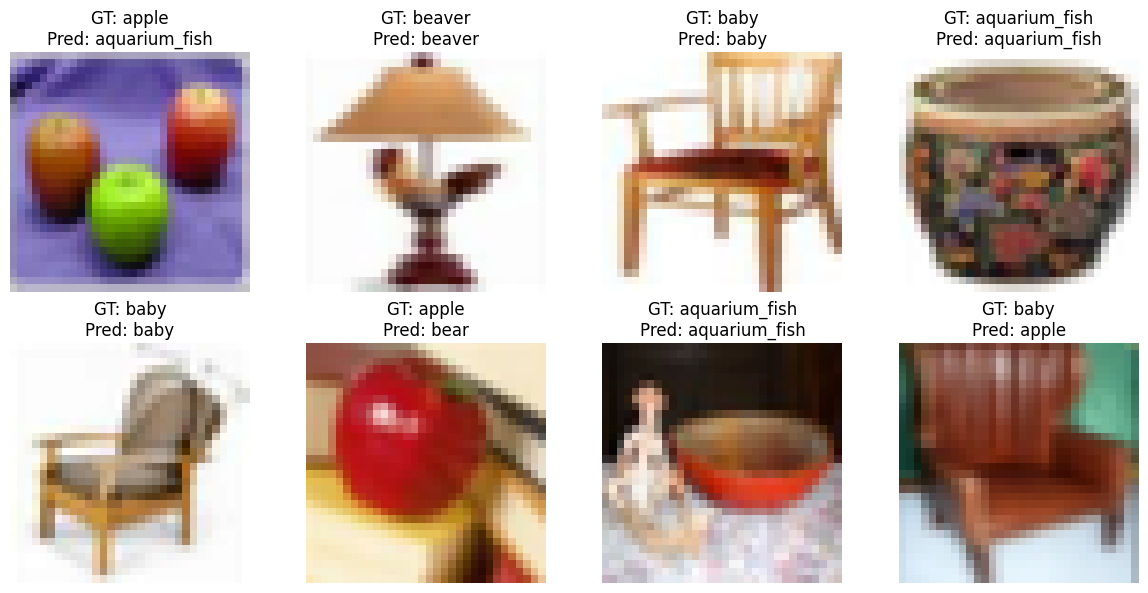

Test Accuracy: 73.00%


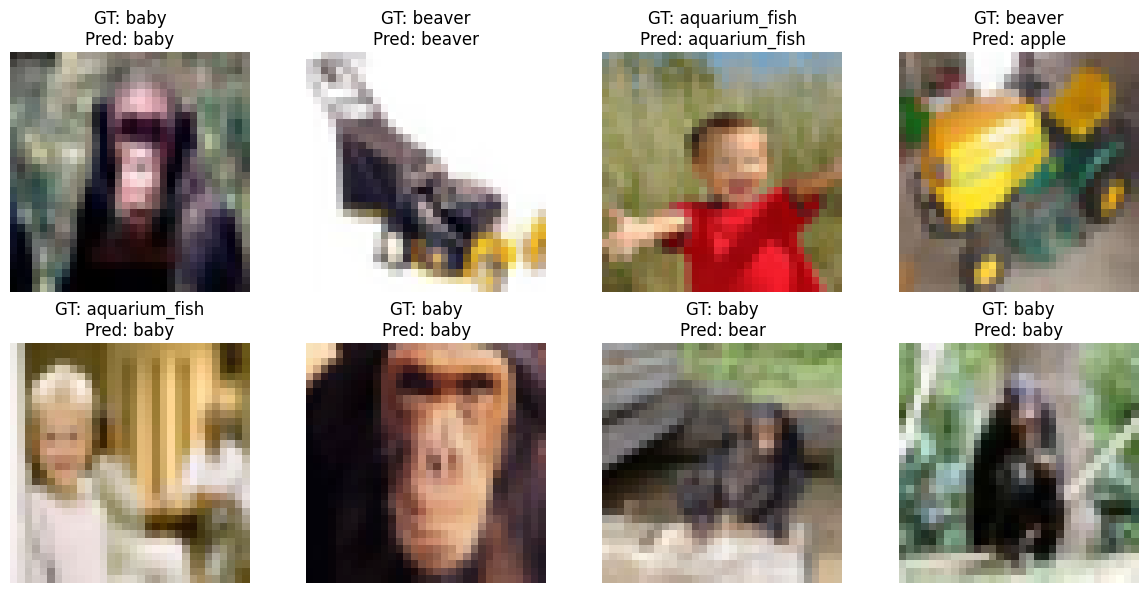

Test Accuracy: 82.20%


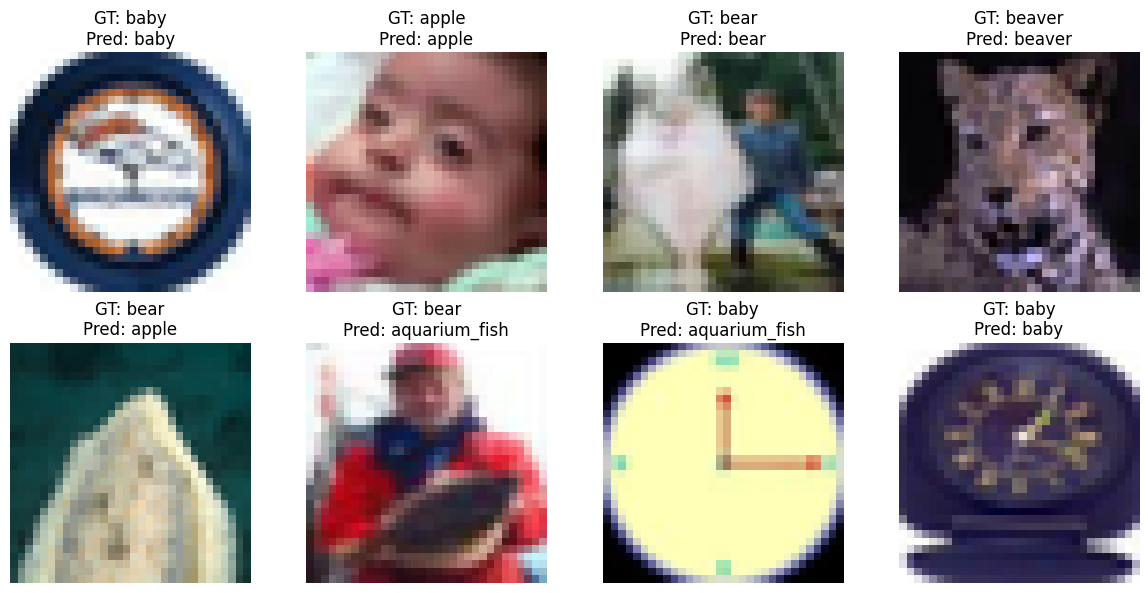

Test Accuracy: 61.00%


In [40]:
def display_images_with_labels(inputs, labels, predictions, classes, num_images=8):

    inputs = inputs.cpu()  # Move inputs to CPU
    labels = labels.cpu()  # Move labels to CPU
    predictions = predictions.cpu()  # Move predictions to CPU

    # Create a grid of images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjust grid size based on num_images
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= num_images:
            break
        img = inputs[i].permute(1, 2, 0).numpy()  # Convert to HWC format
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"GT: {classes[labels[i]]}\nPred: {classes[predictions[i]]}")

    plt.tight_layout()
    plt.show()

def MoE (gateway_model, submodels, dataloader, device):
    gateway_model.eval()  # Set the gateway model to evaluation mode
    for submodel in submodels:
        submodel.eval()  # Set all submodels to evaluation mode
    correct = 0
    total = 0
    images_displayed = False  # To ensure images are displayed only once
    # Initialize dictionaries for routing and results
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in dataloader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the gateway model
            gateway_outputs = gateway_model(inputs)
            probabilities = torch.softmax(gateway_outputs, dim=1)
            
            # Forward pass through all submodels (experts)
            expert_outputs = torch.stack([submodel(inputs) for submodel in submodels], dim=1) 
            # Shape: [batch_size, num_experts, output_dim]
            
            # Compute the final output as a weighted sum of expert outputs
            probabilities = probabilities.unsqueeze(2)  # Shape: [batch_size, num_experts, 1]
            final_output = torch.sum(probabilities * pow(expert_outputs, 19), dim=1)  # Shape: [batch_size, output_dim]
            
            # Compute predictions from the final output
            _, predicted_classes = torch.max(final_output, 1)

            # Compare with true labels for accuracy
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)
                        # Display images with GT and Pred labels for the first batch
            if not images_displayed:
                display_images_with_labels(inputs, labels, predicted_classes, classes, 10)
                images_displayed = True

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")  
    return accuracy * 100

gate_model = GatingNetwork(num_sub_classifiers = gnDataset).to(device)
gate_saved_path = f"{gBase_path}/Gateway/gateway_weights.pth"
checkpoint = torch.load(gate_saved_path, map_location=device)
gate_model.load_state_dict(checkpoint) 

test_dataloaders = []
for i in range(gnDataset):
    train_dataloader, test_dataloader = load_data(train_data_paths[i], test_data_paths[i])
    test_dataloaders.append(test_dataloader)
    
for idx, test_dataloader in enumerate(test_dataloaders):
    data_accuracies[idx]["MoE"] = MoE(gateway_model=gate_model, 
                    submodels=submodels, 
                    dataloader=test_dataloader, 
                    device=device)

Visualize the merging models comparison

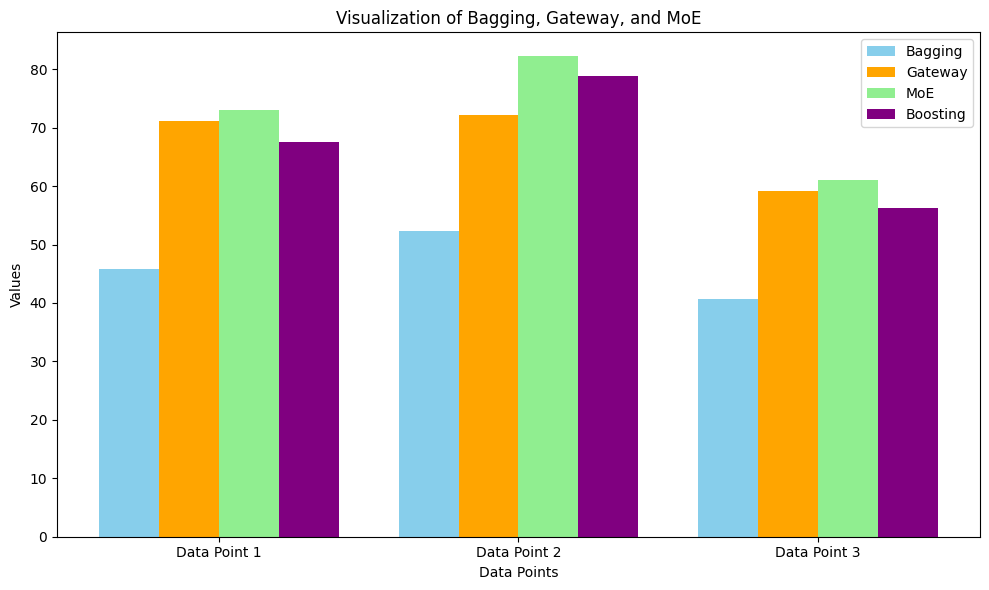

In [36]:
import numpy as np


# Extract values for visualization
labels = ['Data Point 1', 'Data Point 2', 'Data Point 3']  # Label for each data point
bagging = [item['bagging'] for item in data_accuracies]
boosting = [item['boosting'] for item in data_accuracies]
gateway = [item['gateway'] for item in data_accuracies]
moe = [item['MoE'] for item in data_accuracies]

# Bar chart positions
x = np.arange(len(labels))  # Bar positions
width = 0.2  # Adjust the width to fit four bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size for better visibility

# Add bars for each metric
ax.bar(x - 1.5 * width, bagging, width, label='Bagging', color='skyblue')
ax.bar(x - 0.5 * width, gateway, width, label='Gateway', color='orange')
ax.bar(x + 0.5 * width, moe, width, label='MoE', color='lightgreen')
ax.bar(x + 1.5 * width, boosting, width, label='Boosting', color='purple')


# Add labels, title, and legend
ax.set_xlabel('Data Points')
ax.set_ylabel('Values')
ax.set_title('Visualization of Bagging, Gateway, and MoE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()